# В ноутбуке обучается GAN для генерации кошачьих мордочек из случайного шума

---

[Ссылка на датасет с котиками](https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models)

---

## Немного прелюдий

In [1]:
! python --version

Python 3.9.19


In [2]:
import torch

In [4]:
torch.cuda.is_available()

True

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Подготовка изображений

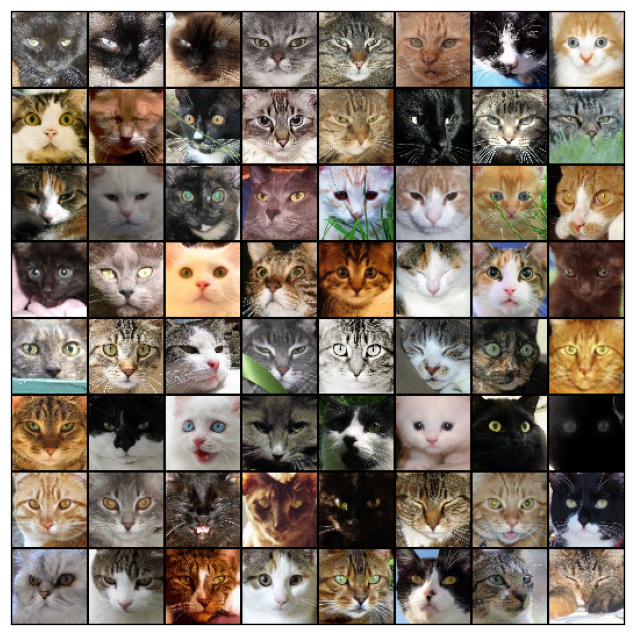

In [26]:
DATA_DIR = '../data/'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [31]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [33]:
train_dl = DeviceDataLoader(train_dl, device)

## Построим генератор и дискриминатор на свертках:

In [34]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [35]:
discriminator = to_device(discriminator, device)

In [36]:
latent_size = 128

In [37]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Посмотрим на шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


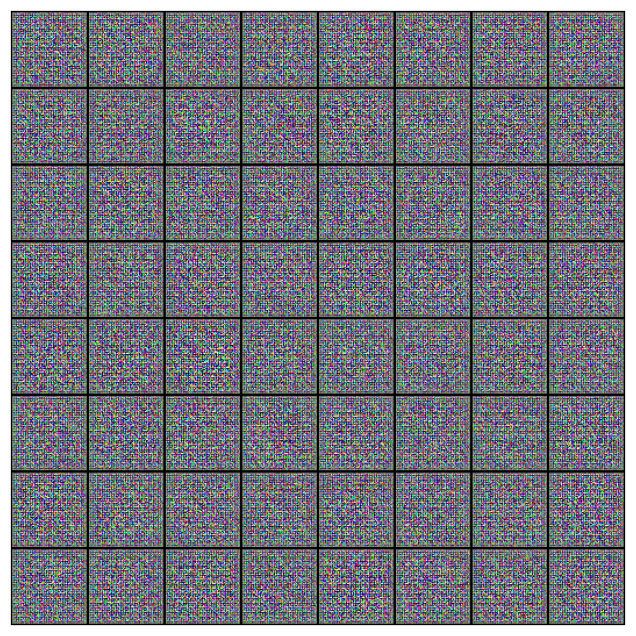

In [38]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [39]:
generator = to_device(generator, device)

In [40]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [41]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [42]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

## Обучаем GAN
#### Алгоритм обучения такой:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * фиксируя веса дискриминатора, говорим, что, вообще-то, истинная метка у сегенерированного изображения должна быть 1
  * обучаем классификатор на два класса (веса дискриминатора в этот момент зафиксированы!), тем самым подгоняя веса генератора создавать изображеня все больше и больше похожие на настоящие (на изображения с меткой 1)

In [43]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [44]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [45]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 7.9791, loss_d: 0.3214, real_score: 0.8899, fake_score: 0.1212


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 6.5572, loss_d: 0.0309, real_score: 0.9833, fake_score: 0.0131


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 4.6929, loss_d: 0.5505, real_score: 0.8340, fake_score: 0.1423


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 3.3492, loss_d: 0.7853, real_score: 0.7449, fake_score: 0.2599


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 3.2913, loss_d: 0.8347, real_score: 0.7197, fake_score: 0.2705


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 3.6420, loss_d: 0.8030, real_score: 0.7386, fake_score: 0.2630


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.0573, loss_d: 0.7701, real_score: 0.7510, fake_score: 0.2456


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.2785, loss_d: 0.7671, real_score: 0.7555, fake_score: 0.2436


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.3519, loss_d: 0.7158, real_score: 0.7686, fake_score: 0.2355


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.3293, loss_d: 0.7744, real_score: 0.7641, fake_score: 0.2329


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.5461, loss_d: 0.6845, real_score: 0.7839, fake_score: 0.2177


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.6653, loss_d: 0.6679, real_score: 0.7865, fake_score: 0.2144


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.4090, loss_d: 0.6812, real_score: 0.7822, fake_score: 0.2130


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.4111, loss_d: 0.7205, real_score: 0.7734, fake_score: 0.2281


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.2553, loss_d: 0.6643, real_score: 0.7856, fake_score: 0.2090


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.2120, loss_d: 0.6173, real_score: 0.8015, fake_score: 0.2049


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.5406, loss_d: 0.5613, real_score: 0.8114, fake_score: 0.1861


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.4400, loss_d: 0.5860, real_score: 0.8146, fake_score: 0.1865


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.4648, loss_d: 0.5316, real_score: 0.8205, fake_score: 0.1759


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.3006, loss_d: 0.5404, real_score: 0.8231, fake_score: 0.1773


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.5553, loss_d: 0.5168, real_score: 0.8264, fake_score: 0.1703


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.8065, loss_d: 0.5666, real_score: 0.8229, fake_score: 0.1757


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 4.8777, loss_d: 0.4929, real_score: 0.8381, fake_score: 0.1624


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 4.8688, loss_d: 0.4729, real_score: 0.8447, fake_score: 0.1610


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 4.9454, loss_d: 0.4414, real_score: 0.8502, fake_score: 0.1452


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 4.9814, loss_d: 0.5118, real_score: 0.8421, fake_score: 0.1550


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 4.5190, loss_d: 0.4290, real_score: 0.8546, fake_score: 0.1466


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 4.9460, loss_d: 0.4928, real_score: 0.8442, fake_score: 0.1483


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 4.8021, loss_d: 0.4372, real_score: 0.8533, fake_score: 0.1505


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 4.8841, loss_d: 0.4379, real_score: 0.8582, fake_score: 0.1408


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 5.1161, loss_d: 0.4169, real_score: 0.8558, fake_score: 0.1379


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 5.3025, loss_d: 0.4023, real_score: 0.8713, fake_score: 0.1293


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 4.8584, loss_d: 0.3720, real_score: 0.8685, fake_score: 0.1302


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.3620, loss_d: 0.4215, real_score: 0.8655, fake_score: 0.1306


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 4.9448, loss_d: 0.3784, real_score: 0.8749, fake_score: 0.1268


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 5.2077, loss_d: 0.3363, real_score: 0.8852, fake_score: 0.1161


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 5.3339, loss_d: 0.3477, real_score: 0.8829, fake_score: 0.1171


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 5.4891, loss_d: 0.3831, real_score: 0.8767, fake_score: 0.1178


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 5.4648, loss_d: 0.3630, real_score: 0.8842, fake_score: 0.1139


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 5.0080, loss_d: 0.4121, real_score: 0.8723, fake_score: 0.1275
Saving generated-images-0040.png


## Смотрим на результаты обучения

In [46]:
losses_g, losses_d, real_scores, fake_scores = history

In [47]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

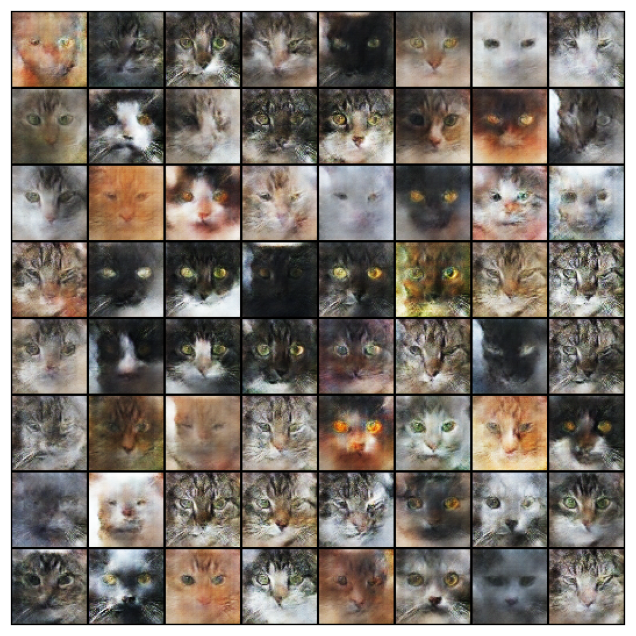

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

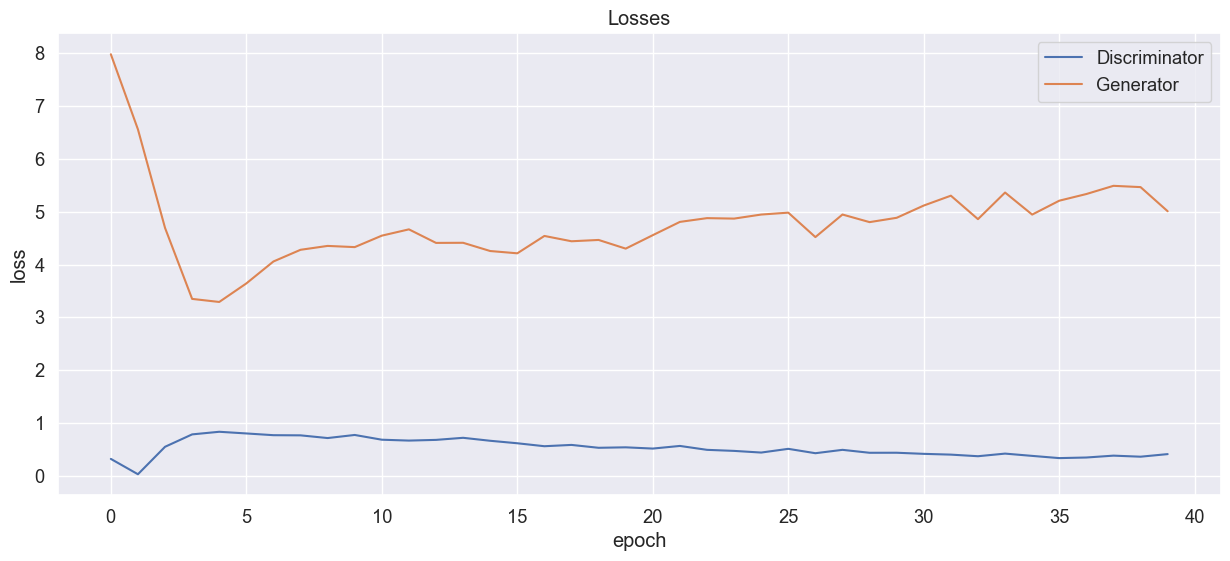

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

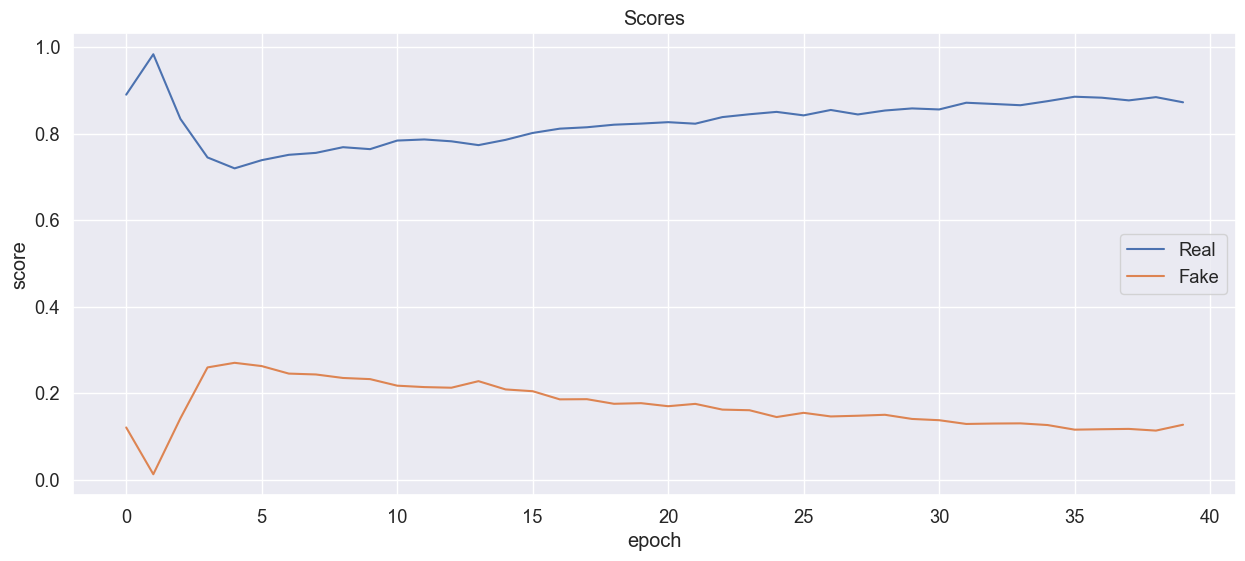

In [50]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Сохраняем веса для дальнейшей имплементации

In [58]:
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [71]:
torch.save(generator, '../model/generator_weights.pth')

## Проверяем работу на случайном шуме

In [72]:
generator_copy = torch.load('../model/generator_weights.pth', weights_only=False)

In [73]:
generator_copy

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [92]:
t = generator_copy(torch.randn(1, 128, 1, 1, device=device))

In [93]:
t

tensor([[[[-0.1202, -0.2827, -0.3933,  ..., -0.2138, -0.3023, -0.2065],
          [-0.3026, -0.3751, -0.5217,  ..., -0.1925, -0.2644, -0.2713],
          [-0.3679, -0.4203, -0.4816,  ..., -0.0478, -0.1756, -0.3319],
          ...,
          [ 0.1489,  0.4160,  0.5651,  ...,  0.7043,  0.7322,  0.6873],
          [ 0.3326,  0.5347,  0.6308,  ...,  0.6649,  0.6125,  0.6005],
          [ 0.3256,  0.3249,  0.3193,  ...,  0.5471,  0.6073,  0.5802]],

         [[-0.2307, -0.3431, -0.4518,  ..., -0.2537, -0.3970, -0.3014],
          [-0.4032, -0.4489, -0.5802,  ..., -0.2644, -0.3652, -0.3916],
          [-0.3968, -0.5076, -0.5264,  ..., -0.1743, -0.2411, -0.4551],
          ...,
          [ 0.0131,  0.3579,  0.5306,  ...,  0.5966,  0.6419,  0.5694],
          [ 0.2799,  0.3601,  0.5912,  ...,  0.5489,  0.4797,  0.5027],
          [ 0.2752,  0.3188,  0.1961,  ...,  0.4252,  0.5372,  0.4807]],

         [[-0.2947, -0.3826, -0.4653,  ..., -0.3249, -0.4367, -0.4217],
          [-0.4342, -0.4973, -

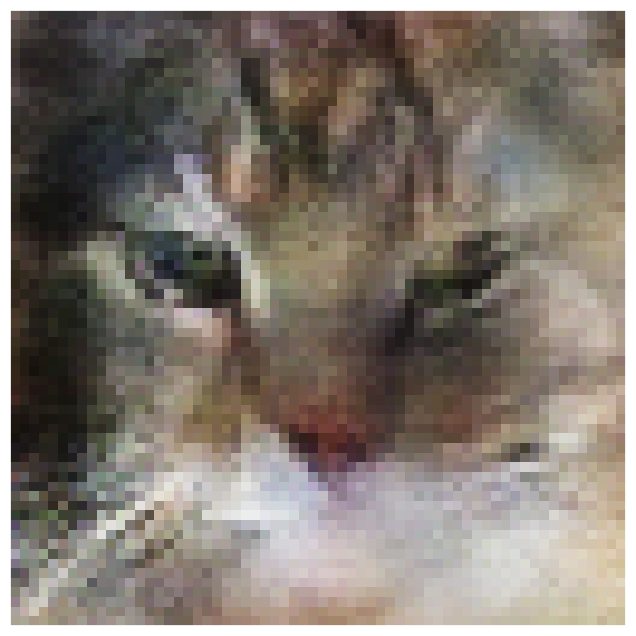

In [95]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(denorm(t).cpu().detach(), nrow=8).permute(1, 2, 0))